In [1]:
import yfinance as yf 
import matplotlib.pyplot as plt
import pandas as pd
from io import StringIO

xly_holdings = '''
NAME	HOLDING ALLOCATION
Amazon.com, Inc.	25.38%
Tesla, Inc.	14.06%
Home Depot, Inc.	8.89%
McDonald's Corporation	4.54%
NIKE, Inc. Class B	4.38%
Lowe's Companies, Inc.	3.91%
Starbucks Corporation	3.80%
Booking Holdings Inc.	3.33%
TJX Companies Inc	2.83%
O'Reilly Automotive, Inc.	1.81%
Chipotle Mexican Grill, Inc.	1.79%
AutoZone, Inc.	1.54%
Marriott International, Inc. Class A	1.50%
General Motors Company	1.42%
Ford Motor Company	1.41%
Hilton Worldwide Holdings Inc	1.20%
Yum! Brands, Inc.	1.20%
Ross Stores, Inc.	1.12%
D.R. Horton, Inc.	1.09%
Lennar Corporation Class A	0.91%
Ulta Beauty Inc.	0.81%
Aptiv PLC	0.79%
Tractor Supply Company	0.79%
eBay Inc.	0.74%
Genuine Parts Company	0.72%
Las Vegas Sands Corp.	0.62%
Darden Restaurants, Inc.	0.61%
NVR, Inc.	0.55%
Royal Caribbean Group	0.54%
Garmin Ltd.	0.49%
PulteGroup, Inc.	0.49%
Expedia Group, Inc.	0.45%
LKQ Corporation	0.44%
Best Buy Co., Inc.	0.44%
Pool Corporation	0.43%
MGM Resorts International	0.42%
Etsy, Inc.	0.36%
CarMax, Inc.	0.36%
Wynn Resorts, Limited	0.35%
Carnival Corporation	0.35%
Domino's Pizza, Inc.	0.34%
BorgWarner Inc.	0.33%
Tapestry, Inc.	0.32%
Caesars Entertainment Inc	0.30%
Bath & Body Works, Inc.	0.27%
Hasbro, Inc.	0.25%
Whirlpool Corporation	0.22%
Advance Auto Parts, Inc.	0.22%
V.F. Corporation	0.21%
Norwegian Cruise Line Holdings Ltd.	0.19%
Mohawk Industries, Inc.	0.16%
Ralph Lauren Corporation Class A	0.14%
State Street Institutional Liquid Reserves Fund	0.12%
Newell Brands Inc	0.10%
'''

xly_holdings = [x.split('\t') for x in xly_holdings.split('\n')][1:]

In [2]:
cols = xly_holdings[0]
vals = xly_holdings[1:]
xly = pd.DataFrame(vals, columns=cols).dropna()
ticks = ['AMZN', 'TSLA', 'HD', 'MCD', 'NKE', 'LOW', 'SBUX', 'BKNG', 'TJX', 'ORLY', 'CMG', 'AZO', 'MAR', 'GM', 'F', 'HLT', 'YUM', 'ROST', 'DHI', 'LEN', 'ULTA', 'APTV', 'TSCO', 'EBAY', 'GPC', 'LVS', 'DRI', 'NVR', 'RCL', 'GRMN', 'PHM', 'EXPE', 'LKQ', 'BBY', 'POOL', 'MGM', 'ETSY', 'KMX', 'WYNN', 'CCL', 'DPZ', 'BWA', 'TPR', 'CZR', 'BBWI', 'HAS', 'WHR', 'AAP', 'VFC', 'NCLH', 'MHK', 'RL', 'STT', 'NWL']
xly.insert(1, 'TICKER', ticks)
xly['HOLDING ALLOCATION'] = [float(x[:-1])/100 for x in xly['HOLDING ALLOCATION']]
xly.rename(columns={'HOLDING ALLOCATION': 'WEIGHT'}, inplace=True)
xly.head()

,NAME,TICKER,WEIGHT
0,"Amazon.com, Inc.",AMZN,0.2538
1,"Tesla, Inc.",TSLA,0.1406
2,"Home Depot, Inc.",HD,0.0889
3,McDonald's Corporation,MCD,0.0454
4,"NIKE, Inc. Class B",NKE,0.0438


In [3]:
dte = '2023-01-01'
XLY = yf.Ticker("XLY").history(start=dte)
ticks = ' '.join(xly.TICKER) 
xly_df = yf.download(ticks, start=dte)

[*********************100%%**********************]  54 of 54 completed


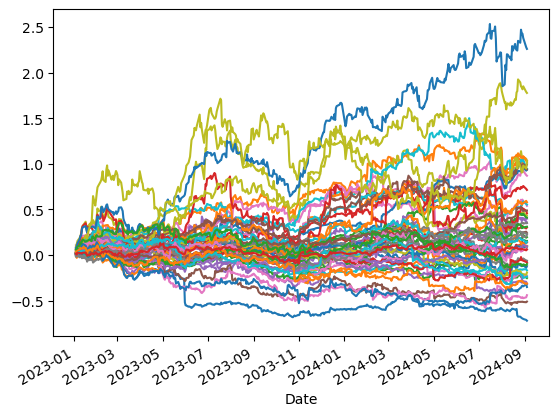

In [4]:
xclose = xly_df['Close']
returns = xclose.pct_change().copy().sort_index()

# Calculate the cumulative return 
cmr = (1 + returns).cumprod() -1
cmr.plot()
# turn off legend
plt.legend().set_visible(False)

# Portfolio Return Formula: $R_p = \sum^n_{i = 1} (w_i * r_i) $

In [5]:
# Cumulative Returns: 
cmr = lambda x: (1+x).cumprod() -1
# XLY 
cmr_xly = (1+(XLY['Close'] - XLY['Close'].shift(1) )/ XLY['Close'].shift(1)).cumprod() -1
cmr_xly.index = pd.to_datetime([str(x)[:10] for x in cmr_xly.index])
print(f'Cumulative Return ETF: {cmr_xly[-1]:.2%}')

# Recreate the index, use the weights to calculate the return 
weights = list(zip(xly.TICKER, xly.WEIGHT))
ordered_etf = xclose[[x[0] for x in weights]]
returns = (ordered_etf / ordered_etf.shift(1)) - 1
weights = [x[1] for x in weights]
weighted_returns = returns * weights
portfolio_returns = weighted_returns.sum(axis=1)
cmr = (1 + portfolio_returns).cumprod() -1
print(f'Cumulative Return Portfolio (Reconstructed): {cmr[-1]:.2%}')


# remvoe amazon and tesla 
weights_a = list(zip(xly.TICKER, xly.WEIGHT))
weights_a = weights_a[2:]
ordered_etf_less = xclose[[x[0] for x in weights_a]]
returns = ordered_etf_less.pct_change().dropna()
weights_a = [x[1] for x in weights_a]
weighted_returns_a = returns * weights_a
portfolio_returns_a = weighted_returns_a.sum(axis=1)
cmra = (1 + portfolio_returns_a).cumprod() -1
print(f'Cumulative Return Portfolio Without Amazon And TSLA: {cmra[-1]:.2%}')


Cumulative Return ETF: 45.99%
Cumulative Return Portfolio (Reconstructed): 56.63%
Cumulative Return Portfolio Without Amazon And TSLA: 14.85%


/var/folders/3z/0n7lmcsd5h3969t725gndl740000gn/T/ipykernel_65984/869177486.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Cumulative Return ETF: {cmr_xly[-1]:.2%}')
/var/folders/3z/0n7lmcsd5h3969t725gndl740000gn/T/ipykernel_65984/869177486.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Cumulative Return Portfolio (Reconstructed): {cmr[-1]:.2%}')
/var/folders/3z/0n7lmcsd5h3969t725gndl740000gn/T/ipykernel_65984/869177486.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFra

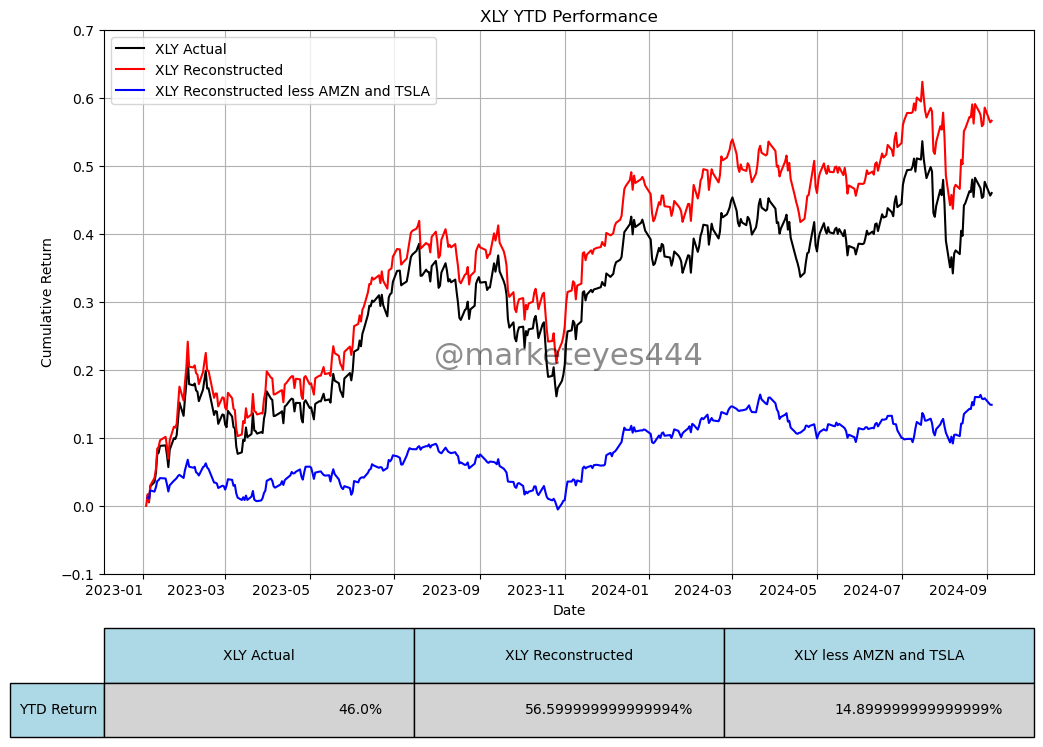

In [6]:

# concatenate tables 
table = pd.concat([cmr_xly, cmr, cmra], axis=1)
table.columns = ['XLY Actual', 'XLY Reconstructed', 'XLY less AMZN and TSLA']
table.index = [str(x)[:10] for x in table.index]
table = table.tail(1).round(3) * 100 
table = table.astype(str) + '%'
table.index = ['YTD Return']


fig, ax = plt.subplots(figsize=(12, 8))
cmr_xly.plot(ax=ax, label='XLY Actual', color='black')
cmr.plot(ax=ax, label='XLY Reconstructed', color='red')
cmra.plot(ax=ax, label='XLY Reconstructed less AMZN and TSLA', color='blue')
#ax.table(cellText=table.values, colLabels=table.columns, rowLabels=table.index, loc='bottom', in_layout = False, transform = ax.transAxes)

# plot the table UNDER the chart, ensure that the x axis labels and ticks are not covered by the table
ax.table(cellText=table.values, cellColours=[['lightgrey']*3],
        colLabels=table.columns, colColours=['lightblue']*3,
        rowLabels=table.index, rowColours=['lightblue']*1, 
        loc='bottom', in_layout = True, 
        transform = ax.transAxes,  bbox=[0.0, -0.3, 1, 0.2])

# change y axis to percentage
vals = ax.get_yticks()
ax.set_yticks(vals)



ax.legend()
ax.set_title('XLY YTD Performance')
ax.set_ylabel('Cumulative Return')
ax.set_xlabel('Date')

ax.text(.5, .4, '@marketeyes444', horizontalalignment='center',verticalalignment='center',transform=ax.transAxes,fontsize=22,alpha=.45)

ax.grid(True)
fig.autofmt_xdate(rotation=0)



In [7]:
table

,XLY Actual,XLY Reconstructed,XLY less AMZN and TSLA
YTD Return,46.0%,56.599999999999994%,14.899999999999999%


In [8]:
import numpy as np 

In [9]:

# Build a function that returns the cumulative return, avg daily ret, volatility of daily return and sharpe ratio, given investment, weights, and price data. 
def portfolio_stats(investment, weights, prices):
    ''' Weights should be in tuple form, with stock and corresponding weight '''
    weights = sorted(weights, key=lambda x: x[1]) # Sort weights. 
    port = prices[[x[0] for x in weights]] # ordered portfolio based on weights 
    norm_port = port/port.iloc[0] # Normalize to 1
    alloc = [x[1] for x in weights] # Get the weights
    alloc = norm_port * alloc # Multiply weights by the normalized prices. (first value will be 1)
    pos_vals = alloc * investment # multiply the normalized prices by the investment amount.
    port_val = pos_vals.sum(axis = 1) # Portfolio value over time, first entry should be = to investment
    daily_returns = port_val.pct_change().dropna()
    cum_ret = (port_val[-1]/ port_val[0] - 1)
    avg_daily_ret = daily_returns.mean()
    std_daily_ret = daily_returns.std()
    daily_rf = 0.0521
    k = 252 # number of trading days in a year
    SR = np.sqrt(k)  * (np.mean(daily_returns - daily_rf)) / std_daily_ret
    print(f'''
    
    Cumulative Return: {cum_ret:.2%}
    Average Daily Return: {avg_daily_ret:.2%}
    Volatility (Daily): {std_daily_ret:.2%}
    Sharpe Ratio: {SR:.2f}
    
    ''')




In [10]:
weights = [('AMZN', .5), ('TSLA', .4), ('F', 0.05), ('GM', 0.05)]
stocks = [x[0] for x in weights]
prices = xclose[stocks]
portfolio_stats(1_000, weights, prices)


    
    Cumulative Return: 94.02%
    Average Daily Return: 0.18%
    Volatility (Daily): 2.11%
    Sharpe Ratio: -37.86
    
    


/var/folders/3z/0n7lmcsd5h3969t725gndl740000gn/T/ipykernel_65984/3512770223.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cum_ret = (port_val[-1]/ port_val[0] - 1)


In [11]:
import calendar

yy = 2023 
mm = 7
print(calendar.month(yy, mm))


     July 2023
Mo Tu We Th Fr Sa Su
                1  2
 3  4  5  6  7  8  9
10 11 12 13 14 15 16
17 18 19 20 21 22 23
24 25 26 27 28 29 30
31

